# Линейная регрессия

https://jakevdp.github.io/PythonDataScienceHandbook/

полезная книга которую я забыл добавить в прошлый раз

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Сгенерим набор данных

$$y = f(x) = 3 x + 6, x \in [0, 30]$$

В наших данных один признак ($x$) и одна целевая переменная ($y$),
следом добавим к целевой переменной немного шума распределенного по нормальному закону $N(0, 10)$

In [2]:
font = {'size'   : 20}
plt.rc('font', **font)

In [3]:
np.random.seed(4242)

X = np.random.rand(60) * 30
y = X * 3 + 6 
y_noisy = y + np.random.normal(scale=10, size=X.shape)

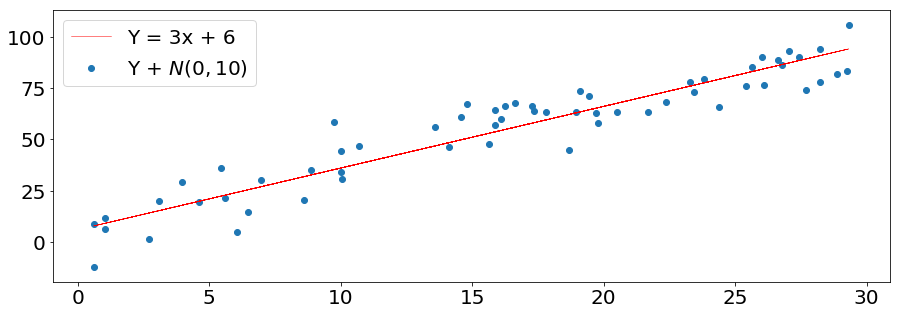

In [4]:
plt.figure(figsize=(15,5))
plt.plot(X, y, label='Y = 3x + 6', color='r', lw=0.5);
plt.scatter(X, y_noisy, label='Y + $N(0, 10)$')
plt.legend();

Задачей регрессии называют задачу восстановления закона (функции) $f(x)$ по набору наблюдений $(x, y)$

In [5]:
print('Несколько первых значений X: ', np.round(X[:5],2))
print('Несколько первых значений Y: ', np.round(y[:5],2))

Несколько первых значений X:  [ 9.75 28.21 27.42  8.6  23.45]
Несколько первых значений Y:  [35.25 90.64 88.26 31.79 76.36]


Вопрос: Мне дали новое значение $x$ которого я раньше не встречал, могу ли я предсказать для него
значение $y$?

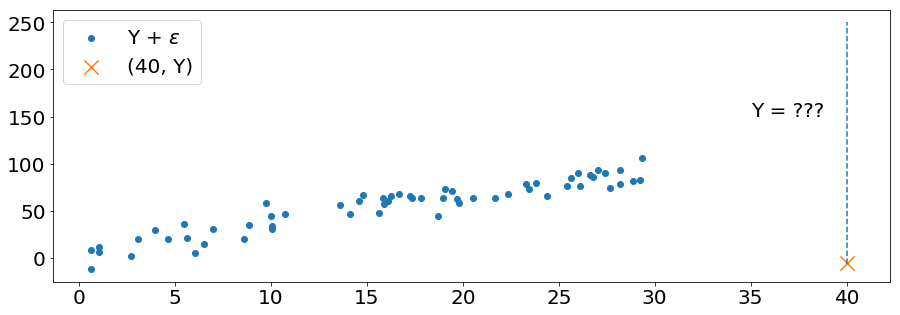

In [6]:
plt.figure(figsize=(15,5))
# plt.scatter(X, y, label='Y', s=10);
plt.scatter(X, y_noisy, label='Y + $\epsilon$')
plt.scatter(40, -5, marker='x', s=200, label='(40, Y)')
plt.plot([40,40], [-7, 250], ls='--');
plt.text(35, 150, 'Y = ???');
plt.legend(loc=2);

Модель линейной регрессии предлагает построить через это облако точек - прямую,
то есть искать функцию $f(x)$ в виде $f(x) = ax + b$, что сводит задачу к поиску двух
коэффициентов $a$ и $b$. Здесь однако возникает два важных вопроса:

1. Предположим мы каким то образом нашли две прямые $(a_1, b_1)$ и $(a_2, b_2)$. 
Как понять какая из этих двух прямых лучше? И что вообще значит, лучше?
2. Как же все-таки найти эти коэффициенты a и b

## 1. Какая прямая лучше?

In [7]:
def plot1(axes, a, b, color='b', X=X, y=y_noisy):
    axes.plot(X, y_noisy, 'r.')
    y_hat = X * a + b
    axes.plot(X, y_hat, color=color, label='y = {}x + {}'.format(a,b))
    axes.legend()

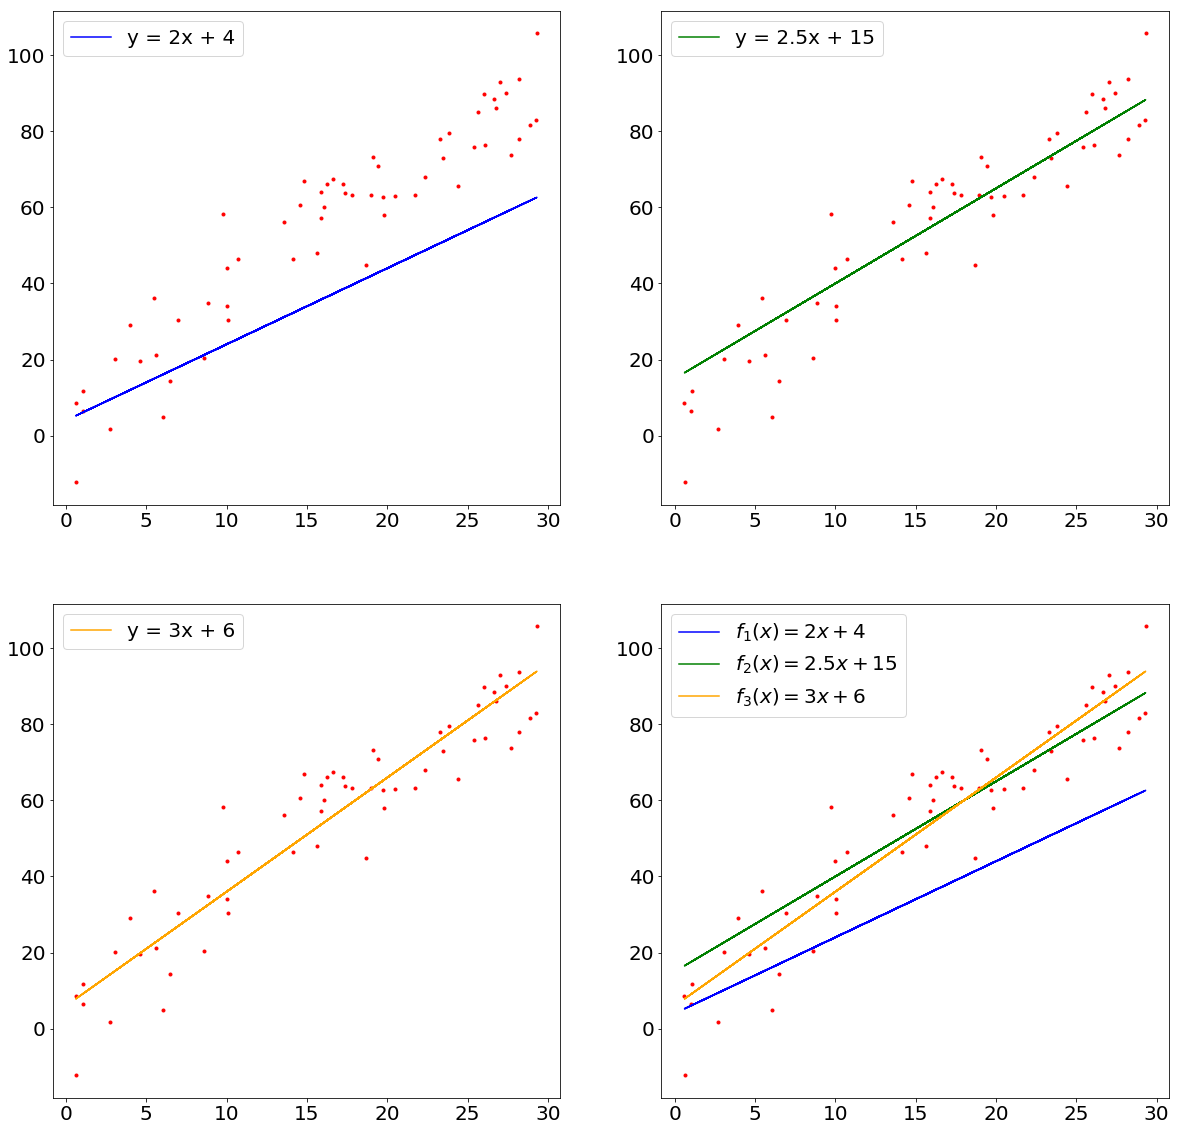

In [8]:
plt.figure(figsize=(20,20))

plot1(plt.subplot(221), 2, 4, 'b')
plot1(plt.subplot(222), 2.5, 15, 'g')
plot1(plt.subplot(223), 3, 6, 'orange')

axes = plt.subplot(224)
axes.plot(X, y_noisy, 'r.')

y_hat = X * 2 + 4
axes.plot(X, y_hat, color='b', label='$f_1(x)=2x+4$')

y_hat = X * 2.5 + 15
axes.plot(X, y_hat, color='g', label='$f_2(x)=2.5x+15$')

y_hat = X * 3 + 6
axes.plot(X, y_hat, color='orange', label='$f_3(x)=3x+6$');

axes.legend();

Кажется что $f_1$ (синяя прямая) отпадает сразу, но как выбрать между оставшимися двумя?
Интуитивный ответ таков: надо посчитать ошибку предсказания. Это значит что для каждой точки из 
набора $X$ (для которой нам известно значение $y$) мы можем воспользовавшись функцией $f(x)$ 
посчитать соответственное $y_{pred}$. И затем сравнить  $y$ и $y_{pred}$.

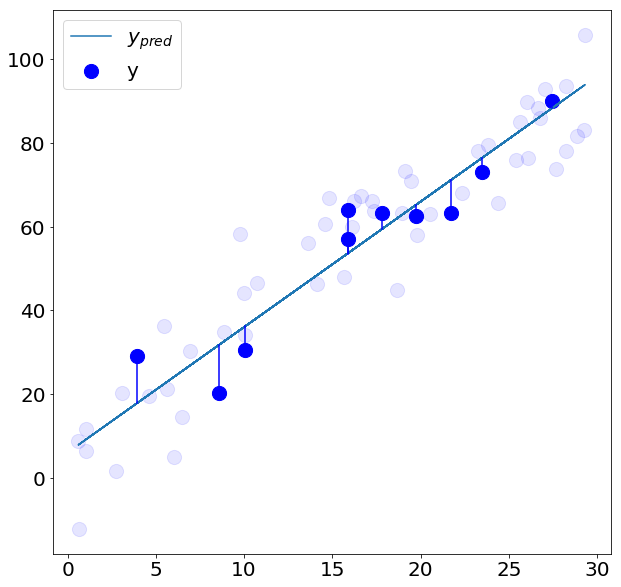

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(X, y_noisy, s=200, c='b', alpha=0.1)
y_hat = X * 3 + 6
plt.plot(X, y_hat, label='$y_{pred}$')

plt.scatter(X[2:12], y_noisy[2:12], s=200, c='b', label='y')

for _x, _y in zip(X[2:12], y_noisy[2:12]):
    plt.plot([_x, _x], [_y, 3*_x+6], c='b')
plt.legend();

Как же считать эту разницу? Существует множество способов:

$$
MSE(\hat{f}, x) = \frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - \hat{f}(x_i)\ \right) ^ 2
$$

$$
MAE(\hat{f}, x) = \frac{1}{N} \sum_{i=1}^{N}\left|\ y_i - \hat{f}(x_i)\ \right|
$$

$$
RMSLE(\hat{f}, x) = \sqrt{\frac{1}{N} \sum_{i=1}^{N}\left(\ \log(y_i + 1) - \log(\hat{f}(x_i) + 1)\ \right)^2}
$$

$$
MAPE (\hat{f}, x) = \frac{100}{N} \sum_{i=1}^{N}\left| \frac{y_i - \hat{f}(x_i)}{y_i} \right|
$$

и другие.

-----
Вопрос: почему бы не считать ошибку вот так

$$
ERROR(\hat{f}, x) = \frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - \hat{f}(x_i)\ \right)
$$

-----

Пока что мы остановимся на MSE. Давайте теперь сравним $f_2(x) = 2.5x+15$ и $f_3(x) = 3x+6$ используя MSE

In [10]:
def mse(y1, y2, prec=2):
    return np.round(np.mean((y1 - y2)**2),prec)

def plot2(axes, a, b, color='b', X=X, y=y_noisy):
    axes.plot(X, y_noisy, 'r.')
    y_hat = X * a + b
    axes.plot(X, y_hat, color=color, label='y = {}x + {}'.format(a,b))
    axes.set_title('MSE = {:.2f}'.format(mse(y_hat, y_noisy)));
    axes.legend()

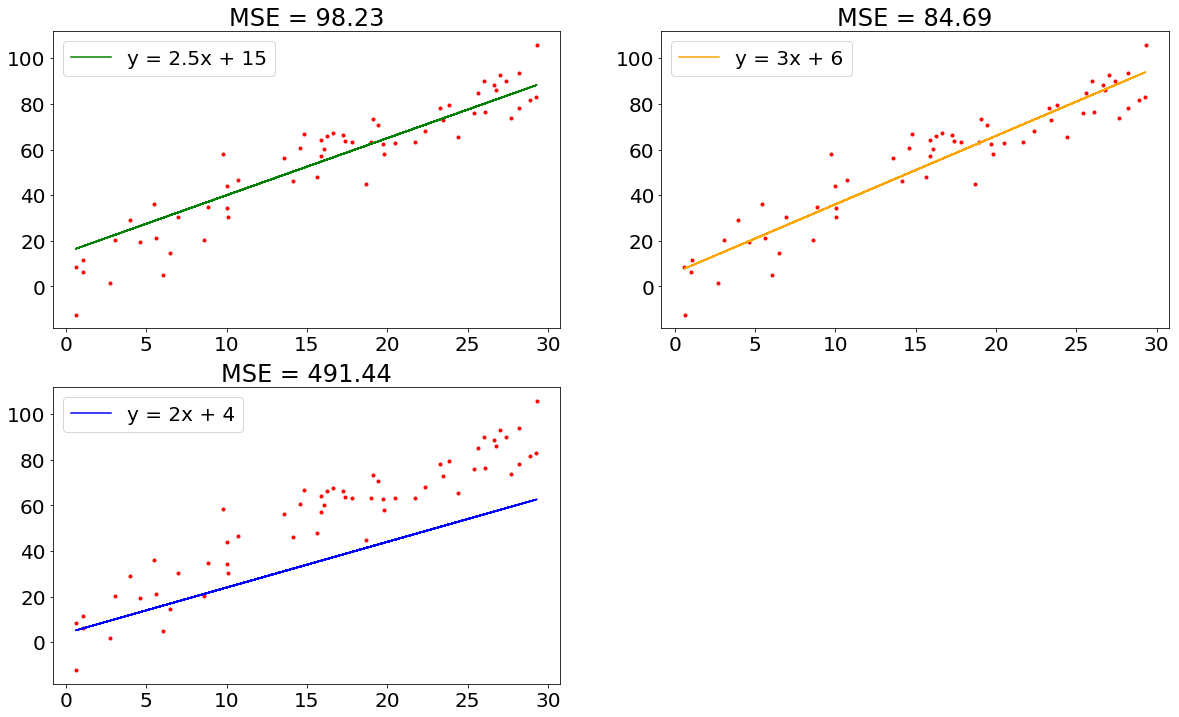

In [11]:
plt.figure(figsize=(20,12))


plot2(plt.subplot(221), 2.5, 15, 'g')
plot2(plt.subplot(222), 3, 6, 'orange')
plot2(plt.subplot(223), 2, 4, 'b')

Понятно что чем меньше значение MSE тем меньше ошибка предсказания, а значит выбирать нужно модель для которой MSE наименьшее. В нашем случае это $f_3(x) = 3x+6$. Отлично, мы ответили на первый вопрос, как из многих прямых выбрать одну, тем попробуем ответить на второй.

## 2. Как найти параметры прямой?

Зафиксируем что нам на текущий момент известно.

1. У нас есть данные ввиде множества пар $X$ и $y$: $\{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$
2. Мы хотим найти такую функцию $\hat{f}(x)$ которая бы минимизировала 
$$MSE(\hat{f}, x) = \frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - \hat{f}(x_i)\ \right) ^ 2 \rightarrow \text{min}$$
3. Мы будем искать $\hat{f}(x)$ в предположении что это линейная функция:
$$\hat{f}(x) = ax + b$$

----

Подставив теперь $\hat{f}(x)$ в выражение для MSE получим:
$$
\frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - ax_i - b\ \right) ^ 2 \rightarrow \text{min}_{a,b}
$$

Сделать это можно по-меньшей мере двумя способами:
1. Аналитически: переписать выражение в векторном виде, посчитать первую производную и приравнять ее к 0, откуда выразить значения для параметров.
2. Численно: посчитать частные производные по a и по b и воспользоваться методом градиентного спуска.

Подробный аналитический вывод можно посмотреть например здесь https://youtu.be/Y_Ac6KiQ1t0?list=PL221E2BBF13BECF6C
(после просмотра также станет откуда взялся MSE). Нам же на будущее будет полезно сделать это в лоб (не особо вдаваясь в причины)

-----


Вектор $y$ имеет размерность $n \times 1$ вектор $x$ так же $n \times 1$, применим следующий трюк: превратим вектор $x$ в матрицу $X$ размера $n \times 2$ в которой первый столбец будет целиком состоять из 1. Тогда обзначив за $\theta = [b, a]$ получим выражение для MSE в векторном виде:

$$
\frac{1}{n}(y - X \theta)^{T}(y - X \theta) \rightarrow min_{\theta}
$$
взяв производную по $\theta$ и приравняв ее к 0, получим:
$$
y = X \theta
$$
поскольку матрица $X$ не квадратная и не имеет обратной, домножим обе части на $X^T$ слева
$$
X^T y = X^T X \theta
$$
матрица X^T X, за редким исключением (каким?) обратима, в итоге получаем выражение для $\theta$:
$$
\theta = (X^T X)^{-1} X^T y
$$

проделаем теперь эти шаги с нашими данными (Формула дающая выражение для $\theta$ называется Normal equation)

In [12]:
print(X.shape, y.shape)
print('----------')
print('Несколько первых значений X: ', np.round(X[:5],2))
print('Несколько первых значений Y: ', np.round(y[:5],2))

(60,) (60,)
----------
Несколько первых значений X:  [ 9.75 28.21 27.42  8.6  23.45]
Несколько первых значений Y:  [35.25 90.64 88.26 31.79 76.36]


In [13]:
X_new = np.ones((60, 2))
X_new[:, 1] = X
y_new = y.reshape(-1,1)

In [14]:
print(X_new.shape, y_new.shape)
print('----------')
print('Несколько первых значений X:\n', np.round(X_new[:5],2))
print('Несколько первых значений Y:\n', np.round(y_new[:5],2))

(60, 2) (60, 1)
----------
Несколько первых значений X:
 [[ 1.    9.75]
 [ 1.   28.21]
 [ 1.   27.42]
 [ 1.    8.6 ]
 [ 1.   23.45]]
Несколько первых значений Y:
 [[35.25]
 [90.64]
 [88.26]
 [31.79]
 [76.36]]


In [15]:
theta = np.linalg.inv((X_new.T.dot(X_new))).dot(X_new.T).dot(y_new)

In [16]:
print(theta)

[[6.]
 [3.]]


Таким образом мы восстановили функцию $f(x) = 3 x + 6$ (что совершенно случайно совпало с $f_3(x)$)

Отлично, это была красивая победа! Что дальше?

А дальше нас интересуют два вопроса:

1. Что если первоначальная функция была взята из нелинейного источника (например $y = 3 x^2 +1$)
2. Что делать если у нас не один признак, а много? (т.е. матрица $X$ имеет размер не $n \times 2$, а $n \times m+1$, где $m$ - число признаков)

## 3. Что если нужно восстановить нелинейную зависимость? 

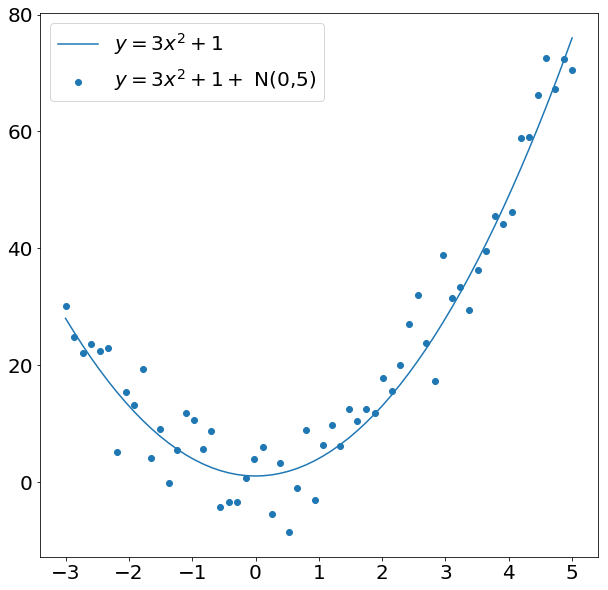

In [17]:
plt.figure(figsize=(10,10))
np.random.seed(4242)
x = np.linspace(-3, 5, 60).reshape(-1,1)
y = 3*x**2 + 1 + np.random.normal(scale=5, size=x.shape)
y_model = 3*x**2 + 1

plt.scatter(x, y, label='$y = 3x^2 + 1 +$ N(0,5)')
plt.plot(x, y_model, label='$y = 3x^2 + 1$')
plt.legend();

Давайте для этого воспользуемся реализацией линейной регрессии из **sklearn**

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
print('y = {} X + {}'.format(np.round(model.coef_[0][0],2), np.round(model.intercept_[0], 2)))

y = 6.13 X + 15.23


Посмотрим теперь как это выглядит

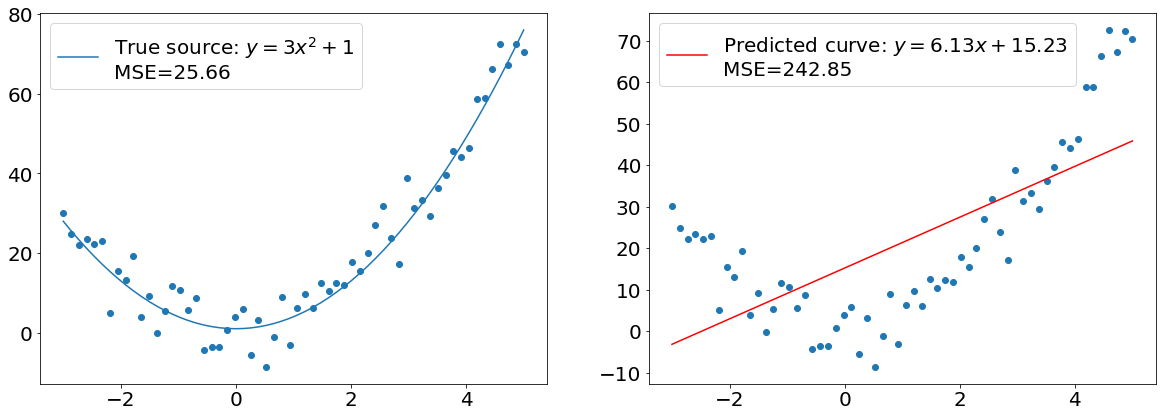

In [21]:
plt.figure(figsize=(20,15))

ax1 = plt.subplot(221)
ax1.scatter(x, y, )
ax1.plot(x, y_model, label='True source: $y = 3x^2 + 1$\nMSE={}'.format(mse(y, y_model)))
ax1.legend();

y_pred = model.coef_[0][0] * x + model.intercept_[0]
ax2 = plt.subplot(222)
ax2.scatter(x, y,)
ax2.plot(x, y_pred, label='Predicted curve: $y = {} x + {}$\nMSE={}'.format(np.round(model.coef_[0][0],2),
                                                                            np.round(model.intercept_[0],2), 
                                                                            mse(y, y_pred)), c='r')

ax2.legend();

Давайте например искать параметры $a$ и $b$ для вот такой функции:
$$
f(x) = ax^2 + b
$$

In [22]:
x_new = x**2

model.fit(x_new, y)
print(model.coef_, model.intercept_)

[[3.02699755]] [1.63872992]


In [23]:
print('y = {} x^2 + {}'.format(np.round(model.coef_[0][0],2), np.round(model.intercept_[0], 2)))

y = 3.03 x^2 + 1.64


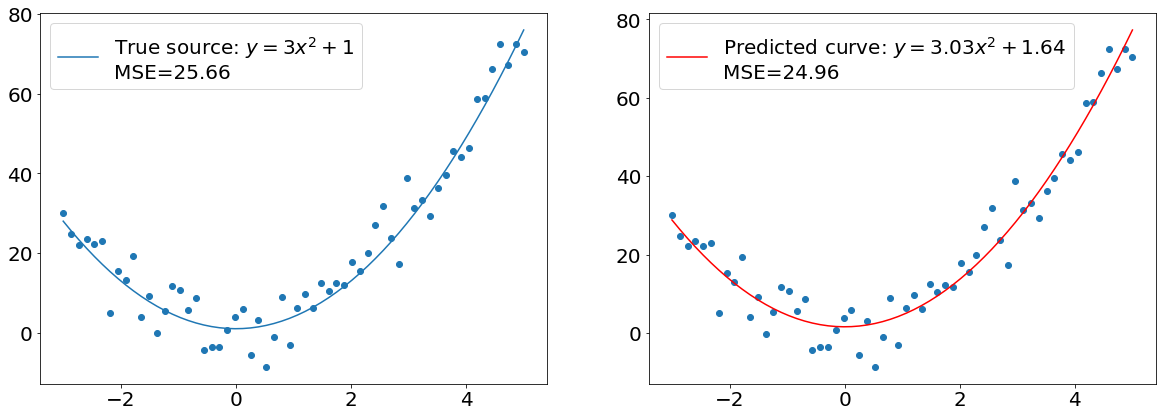

In [24]:
plt.figure(figsize=(20,15))

ax1 = plt.subplot(221)
ax1.scatter(x, y, )
ax1.plot(x, y_model, label='True source: $y = 3x^2 + 1$\nMSE={}'.format(mse(y, y_model)))
ax1.legend();

y_pred = model.coef_[0][0] * x_new + model.intercept_[0]
ax2 = plt.subplot(222)
ax2.scatter(x, y,)
ax2.plot(x, y_pred, label='Predicted curve: $y = {} x^2 + {}$\nMSE={}'.format(np.round(model.coef_[0][0],2),
                                                                            np.round(model.intercept_[0],2), 
                                                                            mse(y, y_pred)), c='r')

ax2.legend();

Некоторые замечания

1. Результирующая функция даже лучше всмысле MSE чем источник (причина - шум)
2. Регрессия все еще называется линейной (собственно линейной она зовется не по признакам X, а по параметрам $\theta$). Регрессия называется линейной потому что предсказываемая величина это **линейная комбинация признаков**, алгоритму неизвестно что мы там что-то возвели в квадрат или другую степень.

3. Откуда я узнал что нужно добавить именно квадратичный признак? (ниоткуда, просто угадал, дальше увидим как это делать)

### 3.1 Задача: воспользуйтесь Normal equation для того чтобы подобрать параметры a и b

Normal equation:
$$
\theta = (X^T X)^{-1} X^T y
$$

Уточнение: подобрать параметры a и b нужно для функции вида $f(x) = ax^2 + b$

## 4. Что делать если у нас не один признак, а много?

Отлично, теперь мы знаем что делать если у нас есть один признак и одна целевая переменная (например предсказывать вес по росту или стоимость квартиры на основе ее площади, или время подъезда такси на основе времени суток). Но что же нам делать если факторов несколько? Для этого давайте еще раз посмотрим на Normal equation:
$$
\theta = (X^T X)^{-1} X^T y
$$

Какие у всех объектов размерности?
$$\theta_{2\times 1} = [[b], [a]]$$
$$X_{n\times 2} = [[1, x_1], [1, x_2], \ldots, [1, x_n]]$$,
$$y_{n\times 1} = [[y_1], [y_2], \ldots, [y_n]]$$


Посчитав $\theta$ как мы будем делать предсказания?
$$
y = x \times \theta
$$
или, если раскрыть $\theta$:

$$
y = 1\times b + x\times a = ax + b
$$

А что если у нас теперь не один признак а несколько (например $m$), как изменятся размерности?
Размерность X станет равна $n\times (m+1)$: $n$ строк и $(m+1)$ столбец (размерность $y$ не изменится), подставив теперь это в Normal equation получим что размерность $\theta$ изменилась и стала равна $(m+1)\times 1$, а предсказания мы будем делать все так же:$y = x \times \theta$ или если раскрыть $\theta$:
$$
y = \theta_0 + x^{[1]}\theta_1 + x^{[2]}\theta_2 + \ldots + x^{[m]}\theta_m
$$

**ВЕРХНИЕ ИНДЕКСЫ ЭТО НОМЕР ПРИЗНАКА (номер столбца в матрице $X$), А НЕ АРИФМЕТИЧЕСКАЯ СТЕПЕНЬ**

-----

Точно так же и в случае если оптимизировать MSE с помощью градиентного метода, просто частные производные нужно ссчитать не по $a$ и $b$, а по всем параметрам $\theta_0, \ldots, \theta_m$.

-----

Теперь давайте попробуем на практике

In [25]:
np.random.seed(4242)

X = np.linspace(-2, 30, 80).reshape(-1, 1)
y = X + 0.1*X**2 - 0.005*X**3- 2

y_noisy = y + np.random.normal(scale=3, size=X.shape)

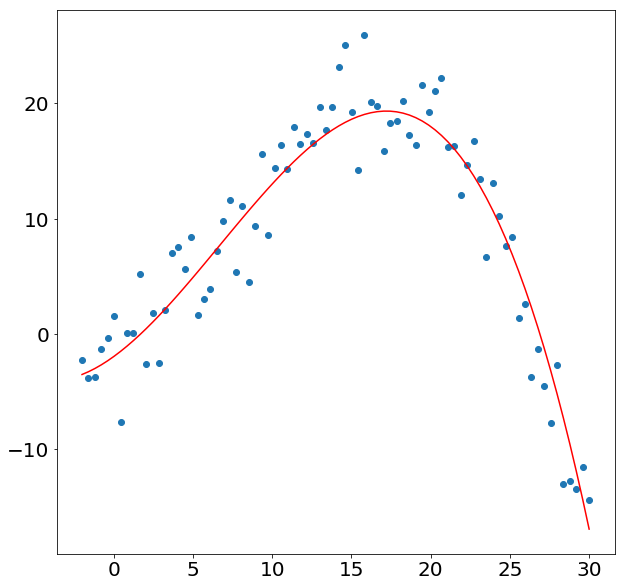

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(X, y_noisy);
plt.plot(X, y, c='r');

Для начала давайте искать $f(x)$ в виде $$f(x) = a x + b x^2 + c$$ для этого надо подготовить матрицу $X$

In [27]:
print(X.shape)
print(X[:3])

(80, 1)
[[-2.        ]
 [-1.59493671]
 [-1.18987342]]


In [28]:
X_new = np.ones((80, 3))
X_new[:, 1] = X[:, 0]
X_new[:, 2] = X[:, 0]**2

In [29]:
X_new.shape

(80, 3)

In [30]:
print(X_new[:5])

[[ 1.         -2.          4.        ]
 [ 1.         -1.59493671  2.54382311]
 [ 1.         -1.18987342  1.41579875]
 [ 1.         -0.78481013  0.61592693]
 [ 1.         -0.37974684  0.14420766]]


In [31]:
def lin_reg(X, y):
    return np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)

In [32]:
theta = lin_reg(X_new, y)

In [33]:
print(np.round(theta, 2))

[[-4.7 ]
 [ 3.15]
 [-0.11]]


Нашли $f(x) = -4.7 + 3.15x - 0.11x^2$

In [34]:
y_pred = X_new.dot(theta)

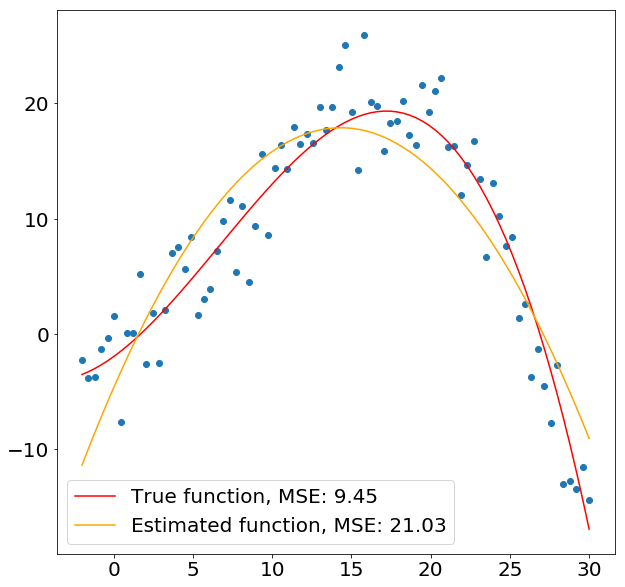

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(X, y_noisy);
plt.plot(X, y, c='r', label='True function, MSE: {}'.format(mse(y_noisy, y)));

plt.plot(X, y_pred, c='orange', label='Estimated function, MSE: {}'.format(mse(y_noisy, y_pred)))
plt.legend();

Добавим признак $x^3$ и посмотрим станет ли лучше

In [36]:
X_new = np.ones((80, 4))
X_new[:, 1] = X[:, 0]
X_new[:, 2] = X[:, 0]**2
X_new[:, 3] = X[:, 0]**3

theta = lin_reg(X_new, y)
print(np.round(theta, 5))

y_pred = X_new.dot(theta)

[[-2.   ]
 [ 1.   ]
 [ 0.1  ]
 [-0.005]]


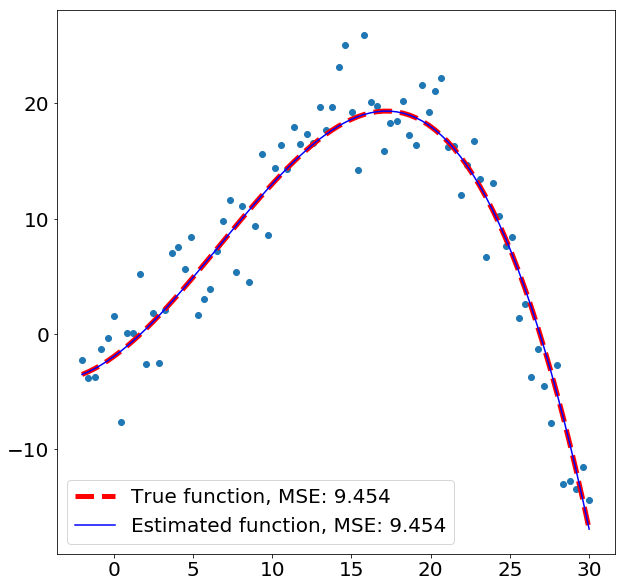

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(X, y_noisy);
plt.plot(X, y, c='r',ls='--', lw=5, label='True function, MSE: {}'.format(mse(y_noisy, y, 3)));

plt.plot(X, y_pred, c='b', label='Estimated function, MSE: {}'.format(mse(y_noisy, y_pred, 3)))
plt.legend();

Отлично, значит мы можем и с несколькими признаками строить линейную регрессию, что же дальше?
А дальше нам надо ответить на (очередные) два вопроса:

1. Как же все-таки подбирать какие признаки генерировать?
2. Как это делать с помощью функций из **sklearn**

Мы ответим на оба вопроса, но сперва разберем пример для того чтобы продемонстрировать
**интерпретируемость** линейной модели

### Задача на определение цен на недвижимость
-----
-----
-----

**Интерпретируемость** линейной модели заключается в том что **увеличение значение признака на 1** ведет к **увелечению целевой переменной** на соответствующее значение **theta** (у этого признака в линейной модели):

$$
f(x_i) = \theta_0 + \theta_1 x_i^{[1]} + \ldots + \theta_j x_i^{[j]} + \ldots + \theta_m x_i^{[m]}
$$

Увеличим значение признака $j$ у наблюдения $x_i$:
$$
\bar{x_i}^{[j]} = x_i^{[j]} + 1 = (x_i+1)^{[j]}
$$

изменение значения функции составит:
$$
\Delta(f(x)) = f(\bar{x}_i) - f(x_i) = \theta_j
$$

In [38]:
import pandas as pd

In [39]:
# данные можно взять отсюда ---> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
# house_data = pd.read_csv('train.csv', index_col=0)
# trunc_data = house_data[['LotArea', '1stFlrSF', 'BedroomAbvGr', 'SalePrice']]
# trunc_data.to_csv('train_house.csv')

house_data = pd.read_csv('train_house.csv', index_col=0)
house_data.head()

,LotArea,1stFlrSF,BedroomAbvGr,SalePrice
Id,,,,
1,8450,856,3,208500
2,9600,1262,3,181500
3,11250,920,3,223500
4,9550,961,3,140000
5,14260,1145,4,250000


In [40]:
X = house_data[['LotArea', '1stFlrSF', 'BedroomAbvGr']].values
y = house_data['SalePrice'].values
# X = (X - X.mean()) / X.std()

In [41]:
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

In [42]:
from sklearn.metrics import mean_squared_log_error

In [43]:
np.sqrt(mean_squared_log_error(y, y_pred))

0.31207207610212556

In [44]:
for y_t, y_p in zip(y[:5], y_pred[:5]):
    print(y_t, np.round(y_p, 3), np.round(mean_squared_log_error([y_t], [y_p]), 6))

208500 144748.305 0.133182
181500 193073.269 0.003821
223500 154092.902 0.138275
140000 157775.392 0.014287
250000 190780.587 0.073081


In [45]:
print(model.coef_)
print(model.intercept_)

[6.59432623e-01 1.17159154e+02 8.34198281e+03]
13861.914863070968


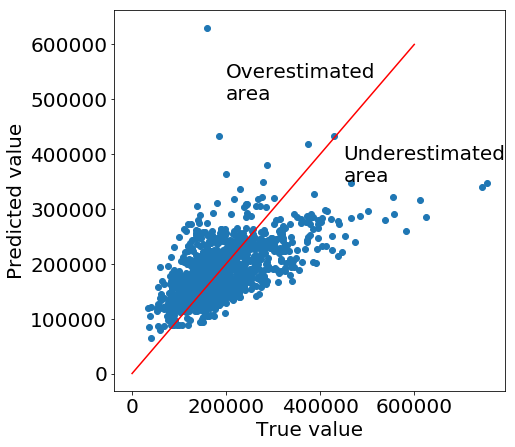

In [46]:
plt.figure(figsize=(7,7))
plt.scatter(y, y_pred);
plt.plot([0, 600000], [0, 600000], c='r');

plt.text(200000, 500000, 'Overestimated\narea')
plt.text(450000, 350000, 'Underestimated\narea')
plt.xlabel('True value')
plt.ylabel('Predicted value');

Вернемся к нашим вопросам:

1. Как же все-таки подбирать какие признаки генерировать?
2. Как это делать с помощью функций из **sklearn**

## 5. Генерация признаков.

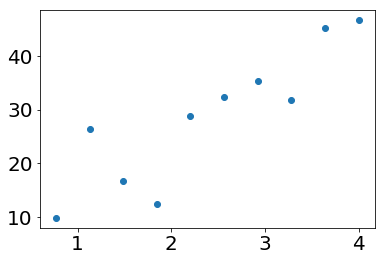

In [47]:
X = np.array([0.76923077, 1.12820513, 1.48717949, 1.84615385, 2.20512821,
       2.56410256, 2.92307692, 3.28205128, 3.64102564, 4.]).reshape(-1,1)

y = np.array([9.84030322, 26.33596415, 16.68207941, 12.43191433, 28.76859577,
       32.31335979, 35.26001044, 31.73889375, 45.28107096, 46.6252025]).reshape(-1,1)

plt.scatter(X, y);

Попробуем простую модель с 1 признаком:

$$
f(x) = ax + b
$$

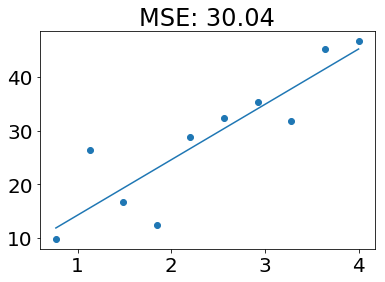

In [48]:
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

plt.scatter(X, y);
plt.plot(X, y_pred);
plt.title('MSE: {}'.format(mse(y, y_pred)));

Добавим квадратичные признаки

In [49]:
from sklearn.preprocessing import PolynomialFeatures

[[1.         0.76923077 0.59171598]
 [1.         1.12820513 1.27284682]
 [1.         1.48717949 2.21170284]]


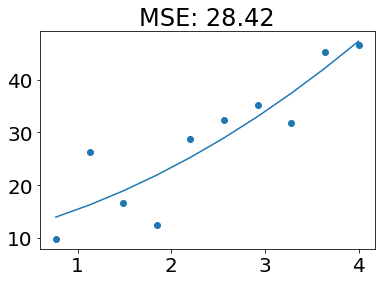

In [50]:
poly = PolynomialFeatures(degree=2)
X_2 = poly.fit_transform(X)

print(X_2[:3])

lr = LinearRegression()
lr.fit(X_2, y)
y_pred_2 = lr.predict(X_2)

plt.scatter(X, y);
plt.plot(X, y_pred_2);
plt.title('MSE: {}'.format(mse(y, y_pred_2)));

Добавим кубические

[[1.         0.76923077 0.59171598 0.45516614]
 [1.         1.12820513 1.27284682 1.43603231]
 [1.         1.48717949 2.21170284 3.28919909]]


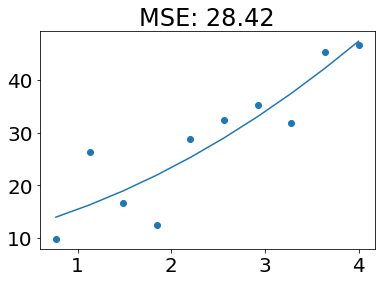

In [51]:
poly = PolynomialFeatures(degree=3)
X_3 = poly.fit_transform(X)
print(X_3[:3])

lr = LinearRegression()
lr.fit(X_3, y)
y_pred_3 = lr.predict(X_3)

plt.scatter(X, y);
plt.plot(X, y_pred_3);
plt.title('MSE: {}'.format(mse(y, y_pred_3)));

We need to go deeper..

In [52]:
def plot3(ax, degree):
    poly = PolynomialFeatures(degree=degree)
    _X = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(_X, y)
    y_pred = lr.predict(_X)

    ax.scatter(X, y);
    ax.plot(X, y_pred, label='MSE={}'.format(mse(y,y_pred)));
    ax.set_title('Polynom degree: {}'.format(degree));
    ax.legend()

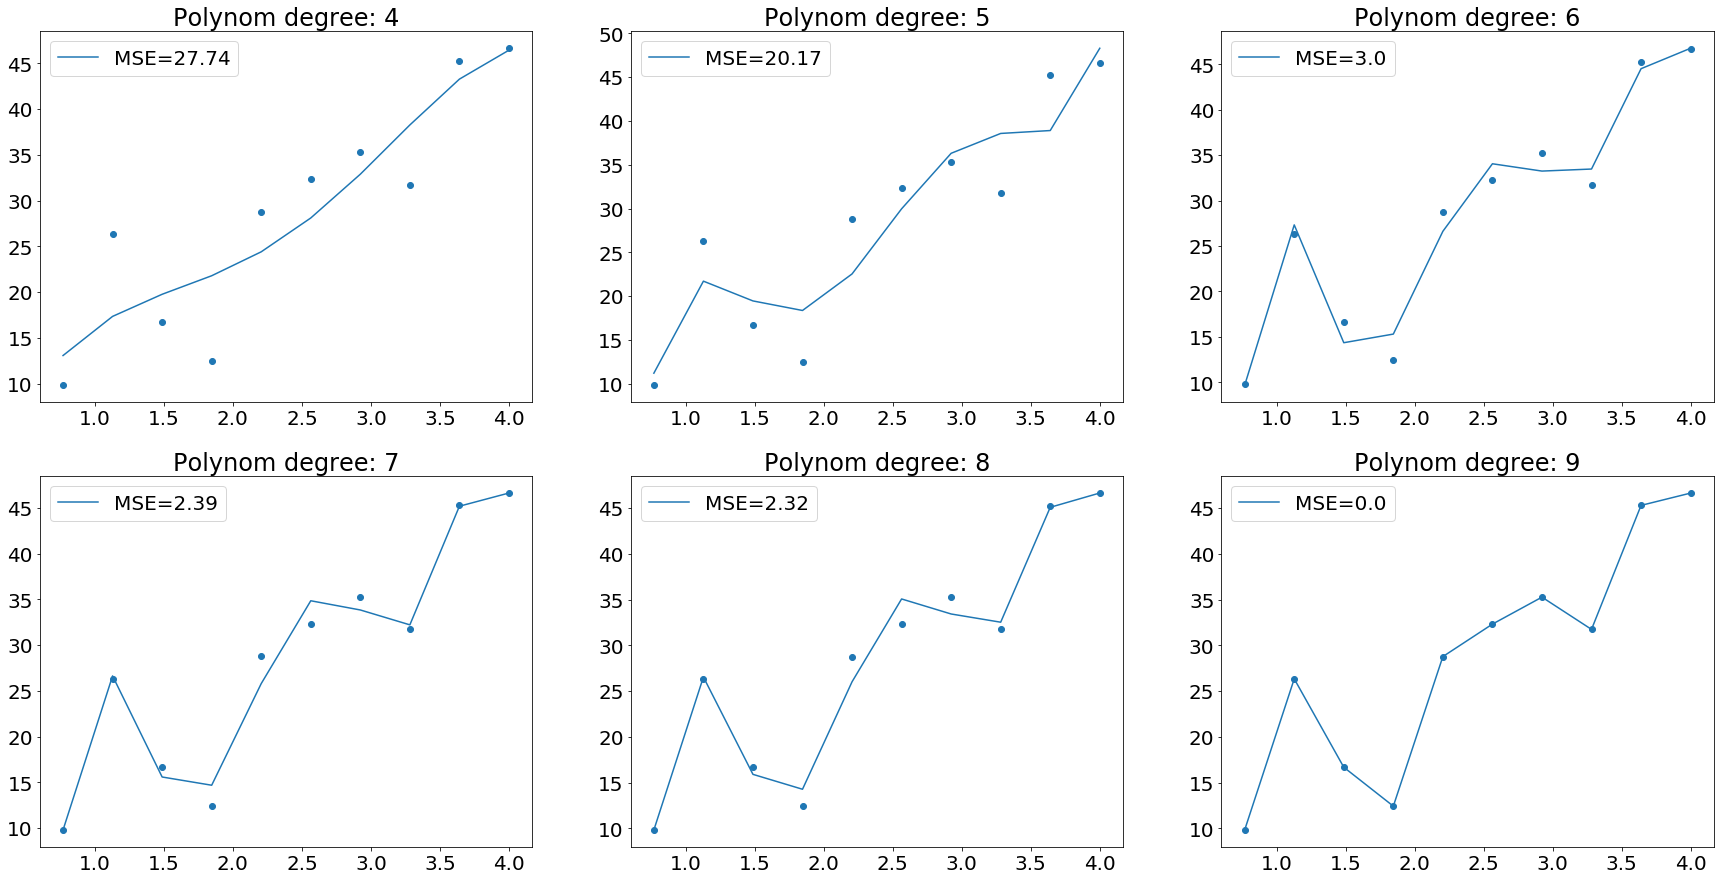

In [53]:
plt.figure(figsize=(30,15))

plot3(plt.subplot(231), 4)
plot3(plt.subplot(232), 5)
plot3(plt.subplot(233), 6)
plot3(plt.subplot(234), 7)
plot3(plt.subplot(235), 8)
plot3(plt.subplot(236), 9)

### Переход в многомерное нелинейное пространство

#### Как сделать регрессию линейной если зависимость нелинейная?

-   $\mathbf{x}$ может зависеть не совсем линейно от $\mathbf{y}$.

-   Перейдем в новое пространство - $\phi(\mathbf{x})$ где $\phi(\cdot)$ это нелинейная функция от $\mathbf{x}$.
    -   В наших примерах присутствуют только полиномы, вообще говоря нелинейо преобразование может быть любым: экспонента, логарифм, тригонометрические функции и пр.

-   Возьмем линейную комбинацию этих нелинейных функций $$f(\mathbf{x}) = \sum_{j=1}^k w_j \phi_j(\mathbf{x}).$$

-   Возьмем некотрый базис функций (например квадратичный базис)
    $$\boldsymbol{\phi} = [1, x, x^2].$$
    
-   Теперь наша функция имеет такой вид
    $$f(\mathbf{x}_i) = \sum_{j=1}^m w_j \phi_{i, j} (x_i).$$


Ну чтож, выходит что полином 9 степени это лучшее что мы можем здесь сделать? или все-таки нет...

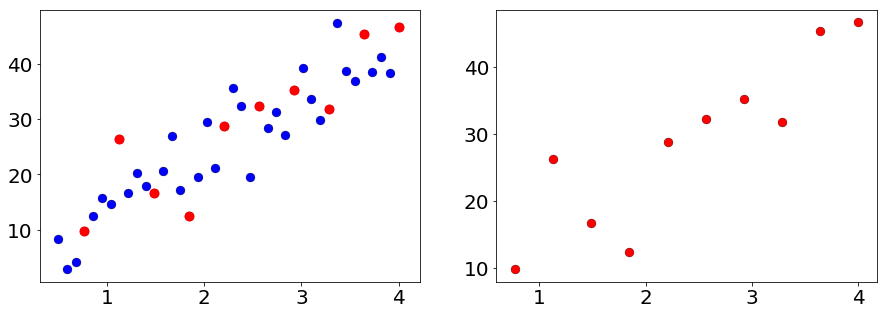

In [54]:
a = 5
b = 10
n_points = 40
x_min = 0.5
x_max = 4

x = np.linspace(x_min, x_max, n_points)[:, np.newaxis]
completely_random_number = 33
rs = np.random.RandomState(completely_random_number)
noise = rs.normal(0, 5, (n_points, 1))

y = a + b * x + noise
idx = np.arange(3,40,4)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x,y, s=80, c ='b', edgecolors='k', linewidths=0.3);
plt.scatter(x[idx],y[idx], s=80, c='r');
plt.subplot(1,2,2)
plt.scatter(x[idx],y[idx], s=80, c ='r', edgecolors='k', linewidths=0.3);

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [56]:
x_train = x[idx]
y_train = y[idx]

lr_linear = LinearRegression(fit_intercept=True)
lr_linear.fit(x_train, y_train)
y_linear = lr_linear.predict(x_train)

# Cubic 
cubic = PolynomialFeatures(degree=3)
x_cubic = cubic.fit_transform(x_train)

lr_3 = LinearRegression(fit_intercept=False)
lr_3.fit(x_cubic, y_train)
y_cubic = lr_3.predict(x_cubic)


# 9'th fit
poly = PolynomialFeatures(degree=9)
x_poly = poly.fit_transform(x_train)

lr_9 = LinearRegression(fit_intercept=False)
lr_9.fit(x_poly, y_train)
y_poly = lr_9.predict(x_poly)


xx = np.linspace(0.75,4,50).reshape(-1,1)
xx_poly = poly.fit_transform(xx)
yy_poly = lr_9.predict(xx_poly)

In [57]:
# PREDICTION ON WHOLE DATA

# linear prediction

y_pred_linear = lr_linear.predict(x)

# cubic prediction

x_cubic_test = cubic.transform(x)
y_pred_cubic = lr_3.predict(x_cubic_test)

# poly 9 prediction

x_poly_test = poly.transform(x)
y_pred_poly = lr_9.predict(x_poly_test)

In [58]:
def plot4(ax, x, y, y_regression, test_idx=None):
    ax.scatter(x,y, s=80, c ='r', edgecolors='k', linewidths=0.3, label='Test');
    ax.plot(x,y_regression);
    if test_idx is not None:
        ax.scatter(x[test_idx], y[test_idx], s=80, c ='b',
                   edgecolors='k',
                   linewidths=0.3,
                  label ='Train');
        ax.legend()
        

    ax.set_title('MSE = {}'.format(np.round(mse(y, y_regression), 2)));

FIRST ROW is TRAIN data set, SECOD ROW is WHOLE data


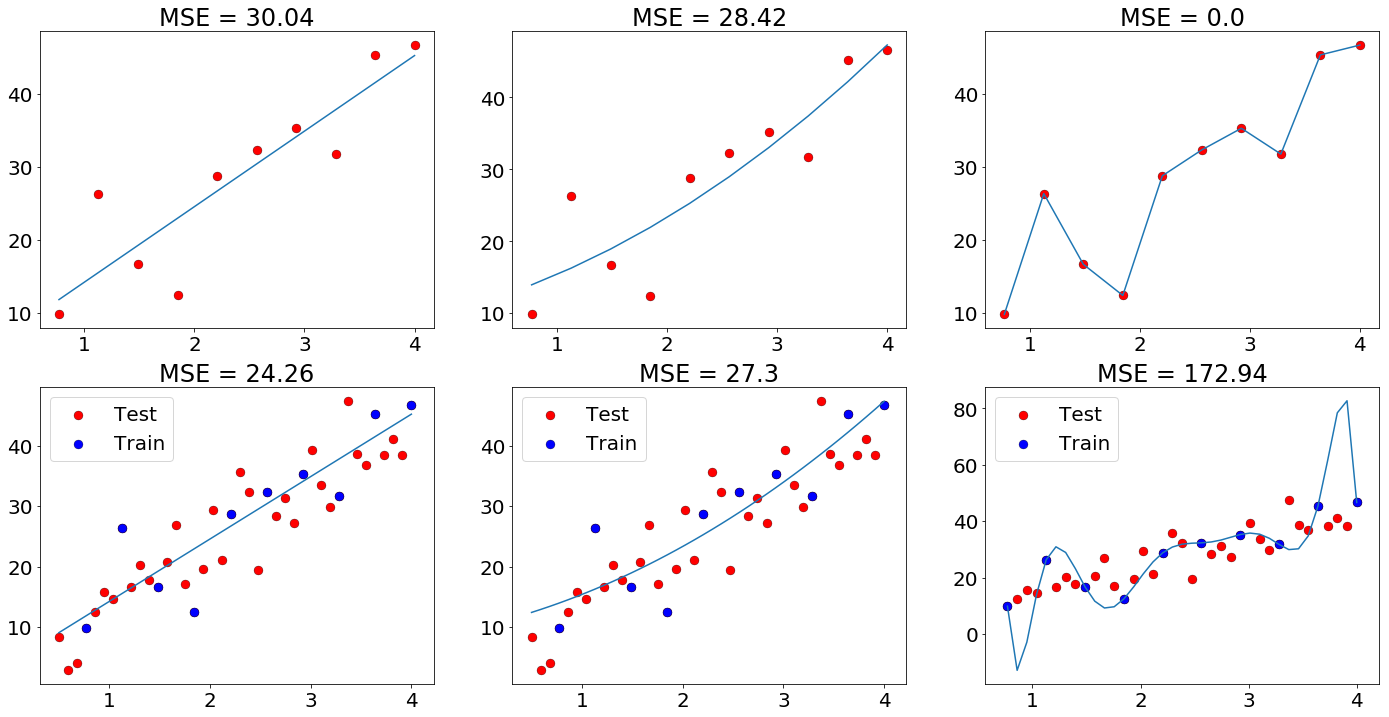

In [59]:
# PLOT PICTURES

plt.figure(figsize=(24,12))


plot4(plt.subplot(231), x_train,y_train,y_linear)
plot4(plt.subplot(232), x_train,y_train,y_cubic)
plot4(plt.subplot(233), x_train,y_train,y_poly)

plot4(plt.subplot(234), x,y,y_pred_linear, test_idx=idx)
plot4(plt.subplot(235), x,y,y_pred_cubic, test_idx=idx)
plot4(plt.subplot(236), x[3:],y[3:],y_pred_poly[3:], test_idx=idx-3)


print('FIRST ROW is TRAIN data set, SECOD ROW is WHOLE data')

#### Вопрос: Почему на графиках в последней колонке поведение функции отличается на TRAIN и TEST данных? (области возрастания, убывания и кривизна)

**Ответ:**

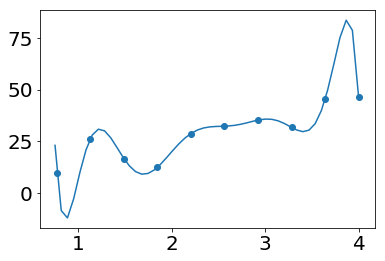

In [60]:
plt.scatter(x_train, y_train)
plt.plot(xx, yy_poly);

In [61]:
mse_train = []
mse_test = []

for degree in range(1,10):
    idx_train = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39]
    idx_test = [ 0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14,
                16, 17, 18, 20, 21, 22, 24, 25, 26, 28,
                29, 30, 32, 33, 34, 36, 38, 39]
    x_train, x_test = x[idx_train], x[idx_test]
    y_train, y_test = y[idx_train], y[idx_test]

    poly = PolynomialFeatures(degree=degree)
    lr = LinearRegression(fit_intercept=True)

    x_train = poly.fit_transform(x_train)
    x_test = poly.transform(x_test)

    lr.fit(x_train, y_train)
    y_pred_train = lr.predict(x_train)
    y_pred_test = lr.predict(x_test)

    mse_train.append(mse(y_train, y_pred_train))
    mse_test.append(mse(y_test, y_pred_test))

In [62]:
mse_train

[30.04, 28.42, 28.42, 27.74, 20.17, 3.0, 2.39, 2.32, 0.0]

In [63]:
mse_test

[22.24, 26.56, 26.52, 23.81, 58.7, 599.61, 298.88, 117.67, 33936.93]

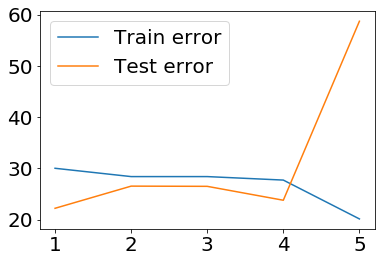

In [64]:
plt.plot(list(range(1,6)), mse_train[:5], label='Train error')
plt.plot(list(range(1,6)), mse_test[:5], label='Test error')
plt.legend();

### Bias-variance tradeoff

$$
y = f(x) + \epsilon
$$
Где $\epsilon$ распределена $N(0, \sigma^2)$

$$
\hat{f}(x) - \text{Восстановленная зависимость}
$$

Таким образом ошибку предсказания:
$$
\text{Err}(x)=E[(y−\hat{f}(x))^2]
$$
можно переписать в виде:
$$
\text{Err}(x)=(E[\hat{f} (x)]−f(x))^2+E[(\hat{f}(x)−E[\hat{f}(x)])^2]+\sigma^2
$$


$$
\text{Err}(x)=\text{Bias}^2+\text{Variance}+\text{Irreducible Error}
$$

Где:
        * Bias - data variability
        * Variance - model variability
        
        
С увеличением сложности модели, ошибка предсказания на тренировочной выборке падает (**Bias**), одновременно с этим возрастает ошибка на тестовой выборке (**Variance**)

![Bias-Variance tradeoff](biasvariance.png)

Подробнее
про bias-variance tradeoff

1. http://scott.fortmann-roe.com/docs/BiasVariance.html
2. http://www.inf.ed.ac.uk/teaching/courses/mlsc/Notes/Lecture4/BiasVariance.pdf

> Переобучаемся под обучающую выборку - слишком "хорошая модель" которая может ловить мега-нелинейные зависимости, которых на самом деле нет.


>> Большие коэффициенты делают возможным сильное изменение величины при небольшом изменении признаков.


### Подход 1

- Добавить больше данных в обучающую выборку

### Подход 2

- Давайте запретим нашим коэффициентам быть большими! (= Упростить модель "автоматически")
    - Ridge
    - Lasso